In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.mixture import GaussianMixture

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, bottleneck_size, hidden_size, layers):
        super(Autoencoder, self).__init__()
        encoder_layers = []
        enc_sizes = [input_size] + [hidden_size] * layers + [bottleneck_size]
        encoder_layers = []
        for r in range(len(enc_sizes)-1):
            inp = enc_sizes[r]
            out = enc_sizes[r+1]
            encoder_layers.append(nn.Linear(inp, out))
            if r<len(enc_sizes) - 2:
                encoder_layers.append(nn.ReLU())
        
        self.encoder = nn.Sequential(*encoder_layers)
        
        dec_sizes = enc_sizes[::-1]
        decoder_layers = []
        
        for r in range(len(dec_sizes)-1):
            inp = dec_sizes[r]
            out = dec_sizes[r+1]
            decoder_layers.append(nn.Linear(inp, out))
            if r<len(dec_sizes)-2:
                decoder_layers.append(nn.ReLU())
        
        self.decoder = nn.Sequential(*decoder_layers)
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded
    
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, code):
        return self.decoder(code)

In [4]:
def train_autoencoder(model, train_loader, lr = 1e-3, epochs = 10, device=device, verbose=True):
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr = lr)
    model.train()
    
    hist = {"train_loss":[]}
    
    for e in range(epochs):
        epoch_loss = 0.0
        for data in train_loader:
            inputs = data[0].to(device)
            optimizer.zero_grad()
            
            code, outputs = model(inputs)
            loss = criterion(outputs, inputs)
            
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item() * inputs.size(0)
            
        epoch_loss = epoch_loss/len(train_loader.dataset)
        hist["train_loss"].append(epoch_loss)
        
        print(f"Epoch {e+1}/{epochs}, Loss: {epoch_loss:.6f}")
        
    return model, hist

In [5]:
def evaluate(model, test_loader, device = device):
    model.eval()
    criterion = nn.MSELoss(reduction = 'mean')
    total = 0.0
    n_samples = 0
    with torch.no_grad():
        for data in test_loader:
            inputs = data[0].to(device)
            _,outputs = model(inputs)
            loss= criterion(outputs, inputs)
            total += loss.item()*inputs.size(0)
            n_samples += inputs.size(0)
    return total/n_samples

In [6]:
def data_setup(n_samples = 1000,noise = 0.1, batch_size = 64, random_state = None):
    X, _ = make_moons(n_samples = n_samples, noise = noise, random_state = random_state)
    X_tensor = torch.tensor(X.astype(np.float32))
    
    dataset = TensorDataset(X_tensor)
    train_loader = DataLoader(dataset, batch_size = batch_size, shuffle = True)
    
    test_loader = DataLoader(dataset, batch_size = len(dataset), shuffle=False)
    
    return train_loader, test_loader, X

In [7]:
def scatterplot(orig, recon=None, n=200, title='Scatter', legend=True):
    plt.figure(figsize = (6,3))
    plt.scatter(orig[:n,0], orig[:n, 1], label = "Original", alpha = 0.6)
    if recon is not None:
        plt.scatter(recon[:n,0], recon[:n, 1], label = "Reconstructed", marker = "x", alpha = 0.8)
    if legend:
        plt.legend()
    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.tight_layout()
    plt.show()
    
def loss_plot (hist, title = "Loss"):
    plt.figure(figsize = (6,3))
    plt.plot(hist["train_loss"], label = "train loss")
    plt.title(title)
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.tight_layout()
    plt.show()

In [8]:
def hist_and_gmm(model, data, n_components = 2, n_samples=1000):
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        x = torch.tensor(data.astype(np.float32)).to(device)
        code = model.encode(x).cpu().numpy()
        
    plt.figure(figsize= (6,3))
    if code.shape[1] ==1 and code.ndim ==2:
        plt.hist(code[:,0], bins = 30)
        plt.title("Bottleneck Code Distribution")
        plt.xlabel("Code Value")
    elif code.shape[1]==2 and code.ndim ==2:
        plt.scatter(code[:,0], code[:,1], s=10)
        plt.title("Bottleneck Code Scatter")
        plt.xlabel("Code dim 0")
        plt.ylabel("Code dim 1")
    else:
        plt.hist(code.flatten(), bins = 30)
        plt.title("Flattened Code Values")
    plt.tight_layout()
    plt.show()
    
    gmm = GaussianMixture(n_components = n_components, random_state = 42)
    gmm.fit(code)
    sample_code, _ = gmm.sample(n_samples)
    
    with torch.no_grad():
        t = torch.tensor(sample_code.astype(np.float32)).to(device)
        synthetic = model.decode(t).cpu().numpy()
    
    plt.figure(figsize = (6,3))
    plt.scatter(data[:,0], data[:, 1], label = "Original Data", alpha = 0.5)
    plt.scatter(synthetic[:,0], synthetic[:,1], label = "GMM Decoded Synthetic Samples" ,marker='x', alpha = 0.8)
    plt.legend()
    
    plt.title("Original Data vs. GMM-decoded Synthetic Samples")
    plt.tight_layout()
    plt.show()
    
    return code, gmm, synthetic

In [9]:
def plot_mean_std(df, x_col, group_filter=None, xlabel = None, ylabel = "Test Reconstruction MSE", title = None, marker = 'o'):
    copy = df.copy()
    if group_filter:
        for i,j in group_filter.items():
            copy = copy[copy[i] == j]
            
    agg = copy.groupby(x_col)['test_loss'].agg(['mean', 'std']).reset_index()
    agg = agg.sort_values(by=x_col)
    x=agg[x_col].values
    y= agg['mean'].values 
    yerr = agg['std'].values
    plt.figure(figsize = (6,3))
    plt.errorbar(x,y, yerr = yerr, marker = marker, capsize = 4, linestyle = '-')
    plt.title(title)   
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()      

In [10]:
def hyperparams(seed = 42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    noise = 0.1
    input_size = 2
    bottleneck_size = 1
    n_samples = 1000
    
    hidden_sizes = [8, 16]
    epochs_list = [10, 50]
    layers_list = [2,3]
    lr_list = [1e-2, 1e-3,]
    
    batch_size = 64
    
    results = []
    total_runs = len(hidden_sizes) * len(layers_list) * len(epochs_list)*len(lr_list) 
    run_index = 0   
    for h in hidden_sizes:
        for l in layers_list:
            for e in epochs_list:
                for lr in lr_list:
                    run_index +=1
                    print(f"Run {run_index}/{total_runs}")
                    train_loader, test_loader, data = data_setup(n_samples = n_samples, noise = noise, batch_size = batch_size, random_state = None)
                    model = Autoencoder(input_size, bottleneck_size,hidden_size = h, layers = l).to(device)
                    model, hist = train_autoencoder(model, train_loader, lr=lr, epochs = e, device=device, verbose = False)
                    
                    test_loss = evaluate(model, test_loader, device = device)
                    
                    print(f"Test loss: {test_loss: .6f}")
                    results.append({'hidden':h, 'layers': l, 'epochs':e, 'lr':lr, 'test_loss': test_loss})
    
    df = pd.DataFrame(results)
    print("Complete. Results (head):")
    print(df.head())
    
    #Testing loss vs Hidden size
    fixed_layer = 2
    fixed_epoch = 50
    fixed_lr = 1e-3
    
    subset = df[(df.layers == fixed_layer) & (df.epochs == fixed_epoch) & (df.lr == fixed_lr)]    

    plt.figure(figsize = (10,5))
    plt.plot(subset['hidden'], subset['test_loss'], marker = 'x')
    plt.title("Test Set Reconstruction Error vs Hidden Size (Layers = 2, Epochs = 50, LR = 1e-3)")
    plt.xlabel("Hidden Layer Size")
    plt.ylabel("Test Reconstruction MSE")
    plt.tight_layout()
    plt.show()
    
    #test loss vs lr
    
    fixed_layer = 2
    fixed_epoch = 50
    fixed_hidden = 16
    
    subset_lr = df[(df.layers == fixed_layer) & (df.epochs == fixed_epoch) & (df.hidden == fixed_hidden)]    

    plt.figure(figsize = (10,5))
    plt.plot(subset_lr['lr'], subset_lr['test_loss'], marker = 'x')
    plt.title("Test MSE vs LR")
    plt.xscale("log")
    plt.xlabel("Learning Rate")
    plt.ylabel("Test Reconstruction MSE")
    plt.tight_layout()
    plt.show()
    
    #test loss vs epochs
    
    fixed_layer = 2
    fixed_epoch = 50
    fixed_hidden = 16
    
    subset_epochs = df[(df.layers == fixed_layer) & (df.hidden== fixed_hidden) & (df.lr == fixed_lr)]   

    plt.figure(figsize = (10,5))
    plt.plot(subset_epochs['epochs'], subset_epochs['test_loss'], marker = 'x')
    plt.title("Test MSE vs Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Test Reconstruction MSE")
    plt.tight_layout()
    plt.show()
    
    best = df.loc[df['test_loss'].idxmin()]
    print(f"Best Hyperparameters Found: {best.to_dict()}")
    
    return best, df

In [11]:
def repeat_training(best_params, repeats = 5, seed = None):

    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)
        
    n_samples = 1000
    noise = 0.1
    batch_size = 64
    losses = []
    
    for i in range(repeats):
        print(f"Repeat{i+1}/{repeats}")
        train_loader, test_loader, _ = data_setup(n_samples=n_samples, noise = noise, batch_size=batch_size, random_state = None)
        model = Autoencoder(input_size=2,bottleneck_size=1, hidden_size=int(best_params['hidden']), layers = int(best_params['layers'])).to(device)
        model, _ = train_autoencoder(model, train_loader, lr = float(best_params['lr']), epochs = int(best_params['epochs']), device = device, verbose = False)
        
        test_loss = evaluate(model, test_loader, device = device)
        print(f"Test Loss: {test_loss:.6f}")
        losses.append(test_loss)
    
    print(f"Mean test loss over {repeats} runs: {np.mean(losses):.6f}")
    print(f"Std Deviation: {np.std(losses):.6f}")
    
    return losses
    

In [12]:
def test_noisy_data(model, noise=0.2):
    _, test_loader, data_np = data_setup(n_samples=1000, noise=noise, batch_size=64)
    test_loss = evaluate(model, test_loader)
    print(f"Test loss on noise level {noise}: {test_loss:.6f}")

    model.eval()
    with torch.no_grad():
        x_tensor = torch.tensor(data_np.astype(np.float32)).to(device)
        _, recon = model(x_tensor)
    recon = recon.cpu().numpy()

    scatterplot(data_np, recon, n=200, title=f"Original vs Reconstructed Data (noise={noise})")

def train_noisy_data(best_params):
    noise = 0.2
    n_samples = 1000
    batch_size = 64

    train_loader, test_loader, data_np = data_setup(n_samples=n_samples, noise=noise, batch_size=batch_size)
    
    model = Autoencoder(
        input_size=2, 
        bottleneck_size=1, 
        hidden_size=int(best_params['hidden']), 
        layers=int(best_params['layers'])
    ).to(device)
    
    print("Training on noise=0.2 data")
    
    train_autoencoder(
    model, 
    train_loader, 
    lr=float(best_params['lr']), 
    epochs=int(best_params['epochs']))
    
    test_loss = evaluate(model, test_loader)
    print(f"Test loss on noise=0.2 training data: {test_loss:.6f}")

    model.eval()
    with torch.no_grad():
        x_tensor = torch.tensor(data_np.astype(np.float32)).to(device)
        _, recon = model(x_tensor)
    recon = recon.cpu().numpy()

    scatterplot(data_np, recon, n=200, title="Original vs Reconstructed Data (noise=0.2)")
    
    return model

Part 1: 
Run 1/16


Epoch 1/10, Loss: 0.539238
Epoch 2/10, Loss: 0.445415
Epoch 3/10, Loss: 0.226349
Epoch 4/10, Loss: 0.127947
Epoch 5/10, Loss: 0.097808
Epoch 6/10, Loss: 0.090783
Epoch 7/10, Loss: 0.083943
Epoch 8/10, Loss: 0.077444
Epoch 9/10, Loss: 0.074923
Epoch 10/10, Loss: 0.072089
Test loss:  0.070343
Run 2/16
Epoch 1/10, Loss: 0.687346
Epoch 2/10, Loss: 0.668484
Epoch 3/10, Loss: 0.650525
Epoch 4/10, Loss: 0.632618
Epoch 5/10, Loss: 0.611906
Epoch 6/10, Loss: 0.589886
Epoch 7/10, Loss: 0.565790
Epoch 8/10, Loss: 0.536955
Epoch 9/10, Loss: 0.503730
Epoch 10/10, Loss: 0.466848
Test loss:  0.445887
Run 3/16
Epoch 1/50, Loss: 0.494671
Epoch 2/50, Loss: 0.280246
Epoch 3/50, Loss: 0.117173
Epoch 4/50, Loss: 0.087880
Epoch 5/50, Loss: 0.073168
Epoch 6/50, Loss: 0.067202
Epoch 7/50, Loss: 0.065249
Epoch 8/50, Loss: 0.062045
Epoch 9/50, Loss: 0.059546
Epoch 10/50, Loss: 0.057237
Epoch 11/50, Loss: 0.056342
Epoch 12/50, Loss: 0.054670
Epoch 13/50, Loss: 0.053145
Epoch 14/50, Loss: 0.050035
Epoch 15/50, Lo

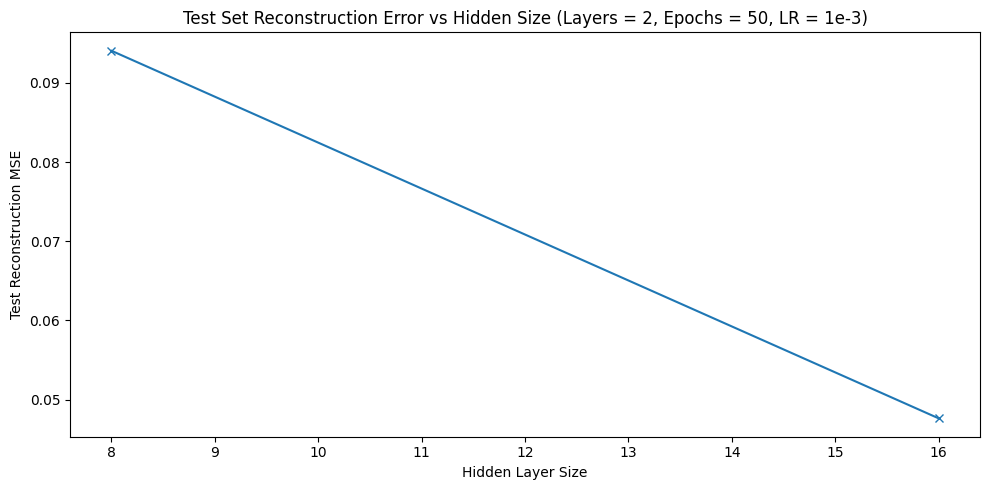

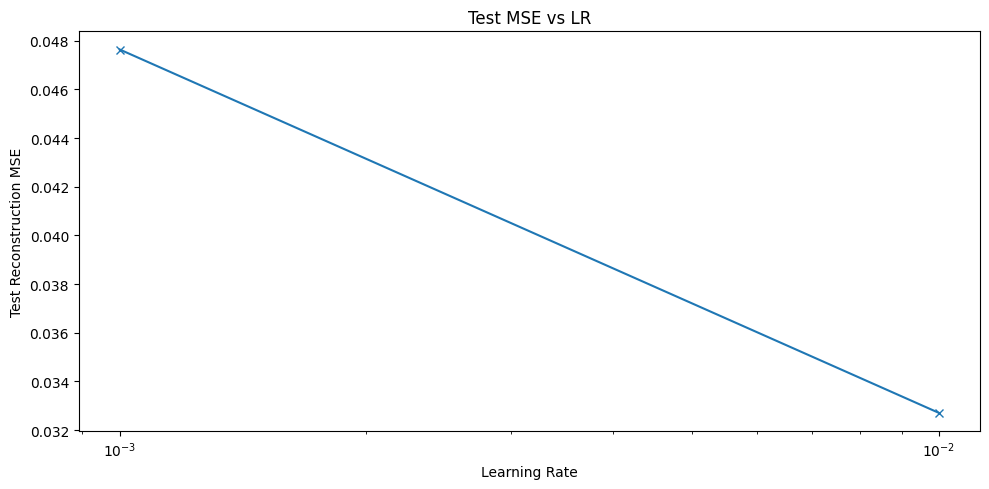

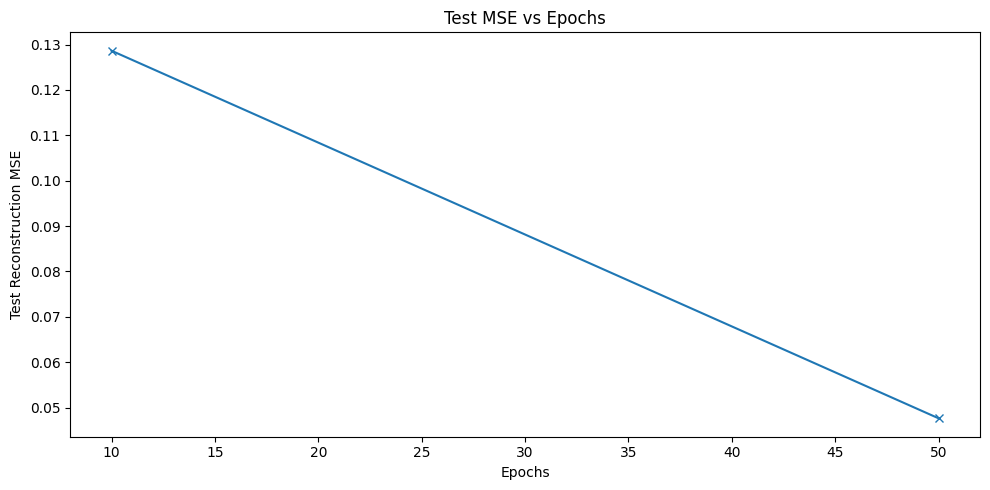

Best Hyperparameters Found: {'hidden': 16.0, 'layers': 3.0, 'epochs': 50.0, 'lr': 0.01, 'test_loss': 0.01853814721107483}


In [13]:
print("Part 1: ")
best_params, df = hyperparams(seed=42)


Part 2: 
Repeat1/3
Epoch 1/50, Loss: 0.518931
Epoch 2/50, Loss: 0.222091
Epoch 3/50, Loss: 0.122012
Epoch 4/50, Loss: 0.103754
Epoch 5/50, Loss: 0.091540
Epoch 6/50, Loss: 0.083657
Epoch 7/50, Loss: 0.077000
Epoch 8/50, Loss: 0.071519
Epoch 9/50, Loss: 0.063910
Epoch 10/50, Loss: 0.058050
Epoch 11/50, Loss: 0.050574
Epoch 12/50, Loss: 0.045844
Epoch 13/50, Loss: 0.043945
Epoch 14/50, Loss: 0.041981
Epoch 15/50, Loss: 0.040953
Epoch 16/50, Loss: 0.038541
Epoch 17/50, Loss: 0.037612
Epoch 18/50, Loss: 0.035965
Epoch 19/50, Loss: 0.034116
Epoch 20/50, Loss: 0.032075
Epoch 21/50, Loss: 0.033497
Epoch 22/50, Loss: 0.033745
Epoch 23/50, Loss: 0.030972
Epoch 24/50, Loss: 0.029787
Epoch 25/50, Loss: 0.027613
Epoch 26/50, Loss: 0.024185
Epoch 27/50, Loss: 0.026154
Epoch 28/50, Loss: 0.025206
Epoch 29/50, Loss: 0.025997
Epoch 30/50, Loss: 0.025976
Epoch 31/50, Loss: 0.025891
Epoch 32/50, Loss: 0.021283
Epoch 33/50, Loss: 0.019016
Epoch 34/50, Loss: 0.019638
Epoch 35/50, Loss: 0.016846
Epoch 36/

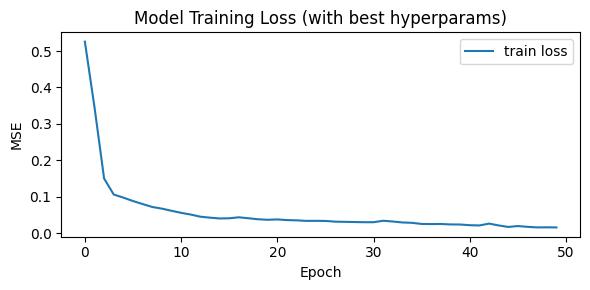

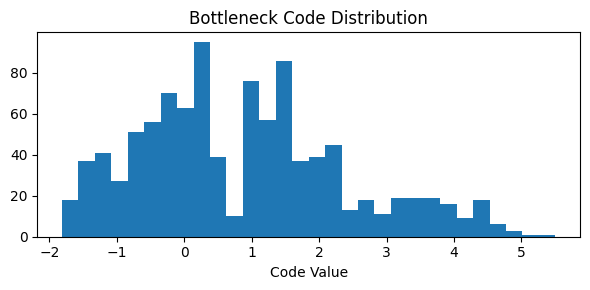

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


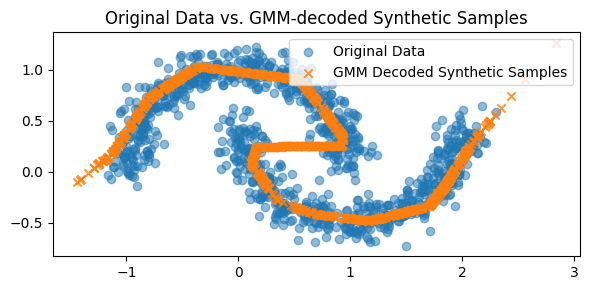


Part 4: 
Test loss on noise level 0.2: 0.058106


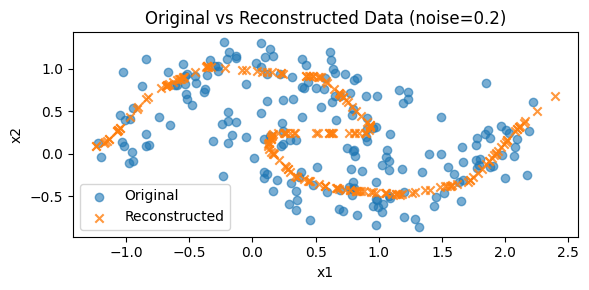


Part 5: 
Training on noise=0.2 data
Epoch 1/50, Loss: 0.578301
Epoch 2/50, Loss: 0.317346
Epoch 3/50, Loss: 0.194789
Epoch 4/50, Loss: 0.130434
Epoch 5/50, Loss: 0.113009
Epoch 6/50, Loss: 0.101246
Epoch 7/50, Loss: 0.093164
Epoch 8/50, Loss: 0.089728
Epoch 9/50, Loss: 0.084797
Epoch 10/50, Loss: 0.081814
Epoch 11/50, Loss: 0.079844
Epoch 12/50, Loss: 0.079450
Epoch 13/50, Loss: 0.075066
Epoch 14/50, Loss: 0.069585
Epoch 15/50, Loss: 0.064877
Epoch 16/50, Loss: 0.060690
Epoch 17/50, Loss: 0.058304
Epoch 18/50, Loss: 0.058953
Epoch 19/50, Loss: 0.057600
Epoch 20/50, Loss: 0.054945
Epoch 21/50, Loss: 0.055068
Epoch 22/50, Loss: 0.052862
Epoch 23/50, Loss: 0.050075
Epoch 24/50, Loss: 0.051066
Epoch 25/50, Loss: 0.050071
Epoch 26/50, Loss: 0.049731
Epoch 27/50, Loss: 0.049508
Epoch 28/50, Loss: 0.046033
Epoch 29/50, Loss: 0.046949
Epoch 30/50, Loss: 0.048707
Epoch 31/50, Loss: 0.045035
Epoch 32/50, Loss: 0.044207
Epoch 33/50, Loss: 0.043555
Epoch 34/50, Loss: 0.042869
Epoch 35/50, Loss: 0

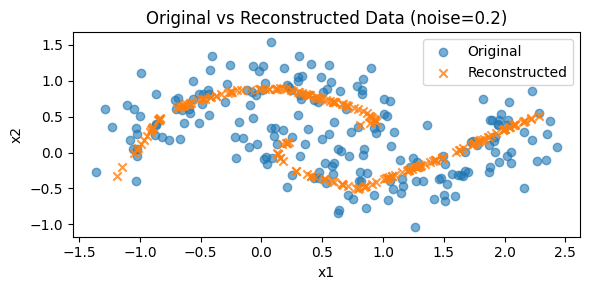

In [15]:
print("\nPart 2: ")
repeat_losses = repeat_training(best_params, repeats=3)

print("\nPart 3: ")
train_loader, test_loader, data_np = data_setup(n_samples=1000, noise=0.1, batch_size=64)
best_model = Autoencoder(
    input_size=2, 
    bottleneck_size=1, 
    hidden_size=int(best_params['hidden']), 
    layers=int(best_params['layers'])
).to(device)
best_model, hist = train_autoencoder(
    best_model, 
    train_loader, 
    lr=float(best_params['lr']),
    epochs=int(best_params['epochs'])
)

loss_plot(hist, title = "Model Training Loss (with best hyperparams)")

code, gmm, synthetic = hist_and_gmm(best_model, data_np, n_components = 2, n_samples = 1000)

print("\nPart 4: ")
test_noisy_data(best_model, noise=0.2)

print("\nPart 5: ")
trained_noisy_model = train_noisy_data(best_params)